### Importing libraries

In [1]:
# Here we shall import all the necessary libraries and functions that we will be using during the tasks.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import pickle
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

### Device

In [2]:
# We decide which device - CPU or GPU - to use for the training purposes.

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Data import and analysis

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])

train_dataset = ImageFolder('..\Lab 6\Face Mask Dataset\Train', transform=transform)
val_dataset = ImageFolder('..\Lab 6\Face Mask Dataset\Validation', transform=transform)
test_dataset = ImageFolder('..\Lab 6\Face Mask Dataset\Test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2, shuffle=True)

In [4]:
# Checking the shape of the input 

print("Train data")
print(len(train_dataset))   # length of the train data
for batch in train_loader:
    images, labels = batch
    print(images.shape)     # shape of the images
    print(labels.shape)     # shape of the labels
    break

print("\nValidation data")
print(len(val_dataset))
for batch in val_loader:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

print("\nTest data")
print(len(test_dataset))
for batch in test_loader:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

Train data
10000
torch.Size([64, 3, 224, 224])
torch.Size([64])

Validation data
800
torch.Size([64, 3, 224, 224])
torch.Size([64])

Test data
990
torch.Size([64, 3, 224, 224])
torch.Size([64])


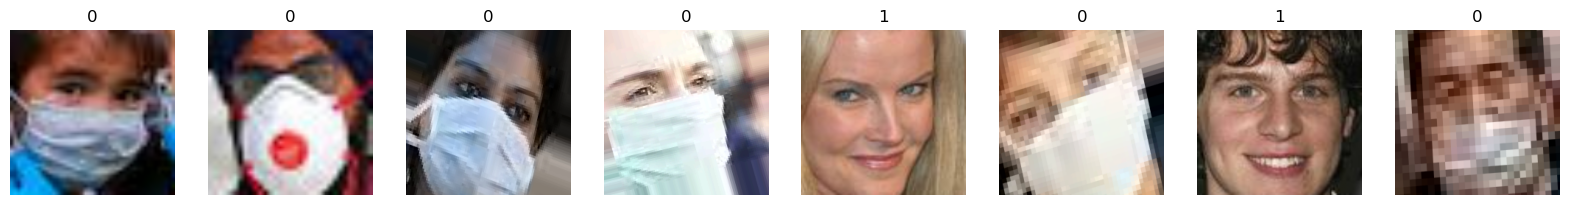

In [5]:
# Checking some samples from the dataset

def show_images(images, labels, ncols=8):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 10))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(labels[i].item())
        ax.axis('off')
    plt.show()

for batch in train_loader:
    images, labels = batch
    show_images(images, labels)
    break

### Hyperparameters

In [6]:
# We define all the necessary training hyperparameters such as batch_size, number of epochs, learning rate, etc.

seed = 42   # for reproducibility
torch.manual_seed(seed)     # set seed for torch
batch_size = 64
epochs = 20
learning_rate = 0.002
image_size = (224,224)

## VAE Architecture

In [7]:
# In this part of the assignment, we use a Variational Autoencoder architecture consisting of a encoder
# and a decoder.

In [8]:
class VAE(nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.branches = []
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256*14*14, latent_dim)
        self.fc_logvar = nn.Linear(256*14*14, latent_dim)
        self.fc = nn.Linear(latent_dim, 256*14*14)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    
    def get_parameters(self, x):
        mean = self.fc_mu(x)
        log_variance = self.fc_logvar(x)
        return mean, log_variance

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean, log_variance = self.get_parameters(x)
        return mean, log_variance
    
    def decode(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 256, 14, 14)
        reconstructed_out = self.decoder(out)
        return reconstructed_out 
    
    def reparameterize(self, mean, log_variance):
        std_dev = torch.exp(0.5*log_variance)
        epsilon = torch.randn_like(std_dev)
        sample = mean + epsilon*std_dev
        return sample

    def forward(self, x):
        mean, log_variance = self.encode(x)
        z = self.reparameterize(mean, log_variance)
        reconstructed = self.decode(z)
        return reconstructed, mean, log_variance


In [9]:
latent_dim = 100
vae = VAE(latent_dim).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
epochs = 25

def calculate_loss(recon_x, x, mean, log_variance):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')           # mean square error loss - reconstruction loss
    KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())       # KL divergence loss
    return MSE + KLD

### Training

#### Training loop

In [10]:
epoch_wise_reconstructed = []
epoch_wise_original = []

In [11]:
def train(vae, train_loader, val_loader, optimizer, epochs):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        
        # Training loop
        vae.train()
        total_loss = 0

        for batch_idx, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            
            x, y = data[0], data[1]
            x = x.to(device)
            
            optimizer.zero_grad()
            recon_batch, mean, log_variance = vae(x)

            loss = calculate_loss(recon_batch, x, mean, log_variance)
            loss.backward()
            total_loss += loss.item() 
            optimizer.step()
        
        train_loss = total_loss / len(train_loader.dataset)

        # Validation loop
        vae.eval()  
        val_loss = 0
        with torch.no_grad():
            for batch_idx, data in enumerate(val_loader):
                x, y = data[0], data[1]
                x = x.to(device)
                recon_batch, mu, logvar = vae(x)
                val_loss += calculate_loss(recon_batch, x, mu, logvar).item()
            
                if epoch%5 == 0 and batch_idx == 0:
                    epoch_wise_reconstructed.append(recon_batch)
                    epoch_wise_original.append(x)
                
        val_loss /= len(val_loader.dataset)

        print('Epoch {} : Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [12]:
train_losses, val_losses = train(vae, train_loader, val_loader, optimizer, epochs)

100%|██████████| 157/157 [00:33<00:00,  4.74it/s]


Epoch 0 : Train Loss: 6257.6272, Val Loss: 3969.0968


100%|██████████| 157/157 [00:32<00:00,  4.84it/s]


Epoch 1 : Train Loss: 2736.0166, Val Loss: 2614.8072


100%|██████████| 157/157 [00:32<00:00,  4.77it/s]


Epoch 2 : Train Loss: 2189.1853, Val Loss: 2185.4417


100%|██████████| 157/157 [00:32<00:00,  4.82it/s]


Epoch 3 : Train Loss: 1945.1376, Val Loss: 2131.1441


100%|██████████| 157/157 [00:32<00:00,  4.78it/s]


Epoch 4 : Train Loss: 1804.6515, Val Loss: 1850.5630


100%|██████████| 157/157 [00:32<00:00,  4.76it/s]


Epoch 5 : Train Loss: 1681.4079, Val Loss: 1880.6024


100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


Epoch 6 : Train Loss: 1606.0410, Val Loss: 1767.4569


100%|██████████| 157/157 [00:32<00:00,  4.77it/s]


Epoch 7 : Train Loss: 1565.2812, Val Loss: 1881.7448


100%|██████████| 157/157 [00:34<00:00,  4.57it/s]


Epoch 8 : Train Loss: 1530.3628, Val Loss: 1663.0665


100%|██████████| 157/157 [00:34<00:00,  4.60it/s]


Epoch 9 : Train Loss: 1430.4781, Val Loss: 1618.5093


100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


Epoch 10 : Train Loss: 1392.4777, Val Loss: 1627.0939


100%|██████████| 157/157 [00:32<00:00,  4.79it/s]


Epoch 11 : Train Loss: 1350.8520, Val Loss: 1561.1968


100%|██████████| 157/157 [00:33<00:00,  4.75it/s]


Epoch 12 : Train Loss: 1346.4025, Val Loss: 1652.6577


100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


Epoch 13 : Train Loss: 1290.4195, Val Loss: 1646.3637


100%|██████████| 157/157 [00:34<00:00,  4.59it/s]


Epoch 14 : Train Loss: 1266.4865, Val Loss: 1581.0965


100%|██████████| 157/157 [00:32<00:00,  4.83it/s]


Epoch 15 : Train Loss: 1250.9629, Val Loss: 1595.6592


100%|██████████| 157/157 [00:32<00:00,  4.82it/s]


Epoch 16 : Train Loss: 1198.3749, Val Loss: 1610.0883


100%|██████████| 157/157 [00:32<00:00,  4.82it/s]


Epoch 17 : Train Loss: 1177.6395, Val Loss: 1836.4300


100%|██████████| 157/157 [00:32<00:00,  4.83it/s]


Epoch 18 : Train Loss: 1171.4065, Val Loss: 1640.6087


100%|██████████| 157/157 [00:33<00:00,  4.71it/s]


Epoch 19 : Train Loss: 1139.8514, Val Loss: 1617.4895


100%|██████████| 157/157 [00:33<00:00,  4.71it/s]


Epoch 20 : Train Loss: 1110.3121, Val Loss: 1719.3793


100%|██████████| 157/157 [00:33<00:00,  4.75it/s]


Epoch 21 : Train Loss: 1114.9018, Val Loss: 1726.0556


100%|██████████| 157/157 [00:33<00:00,  4.72it/s]


Epoch 22 : Train Loss: 1084.2819, Val Loss: 1622.5333


100%|██████████| 157/157 [00:33<00:00,  4.71it/s]


Epoch 23 : Train Loss: 1054.7961, Val Loss: 1637.4003


100%|██████████| 157/157 [00:32<00:00,  4.77it/s]


Epoch 24 : Train Loss: 1052.0932, Val Loss: 1717.3957


#### Image Plots during Training

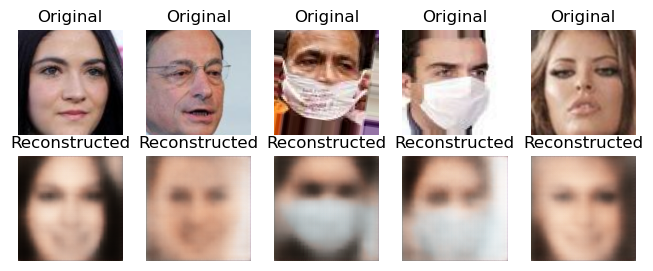

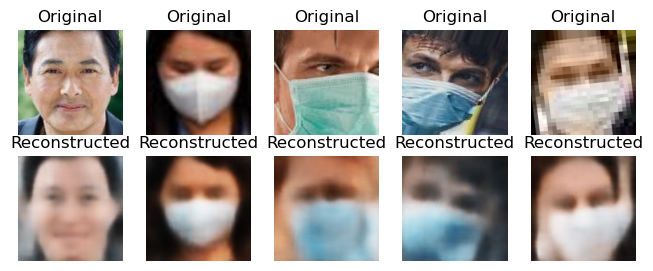

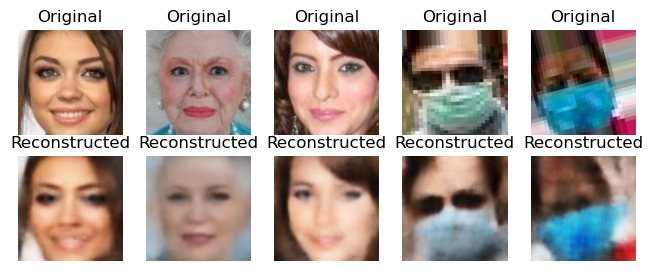

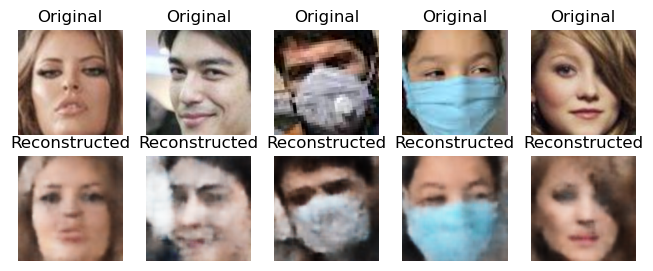

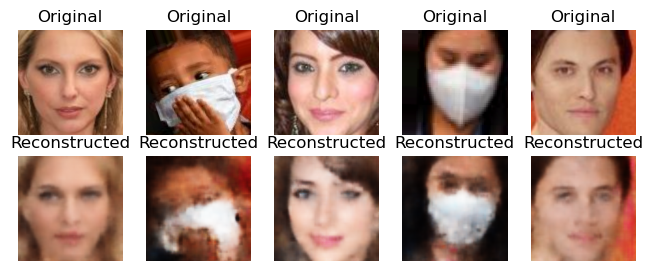

In [21]:
for epoch in range(len(epoch_wise_reconstructed)):
    original = epoch_wise_original[epoch].cpu()
    reconstructed = epoch_wise_reconstructed[epoch].cpu()
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 3))
    
    for i in range(5):
        axes[0, i].imshow(original[i].permute(1, 2, 0))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0))
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.show()
    

#### Loss curves for training and validation

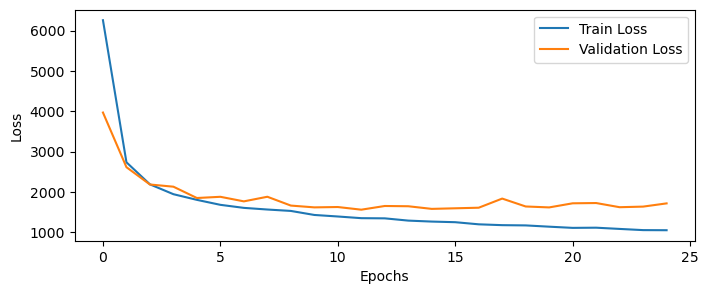

In [14]:
plt.figure(figsize=(8, 3))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing on test data

In [25]:
vae.eval()  
test_loss = 0
test_reconstructions = []
test_originals = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        x, y = data[0], data[1]
        x = x.to(device)
        recon_batch, mu, logvar = vae(x)
        test_loss += calculate_loss(recon_batch, x, mu, logvar).item()
    
        if batch_idx == 0:
            test_reconstructions.append(recon_batch)
            test_originals.append(x)
        
test_loss /= len(test_loader.dataset)

print('Test Loss: {:.4f}'.format(test_loss))

Test Loss: 1676.5755


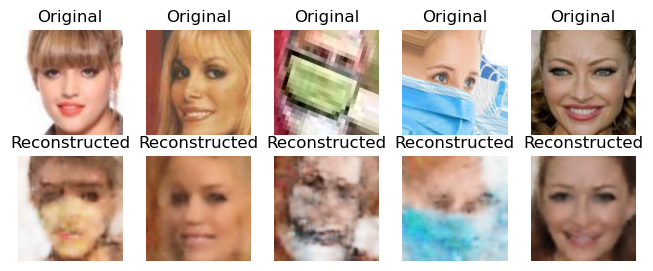

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 3))

for i in range(5):
    axes[0, i].imshow(test_originals[0][i].cpu().permute(1, 2, 0))
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(test_reconstructions[0][i].cpu().permute(1, 2, 0))
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.show()

### TSNE

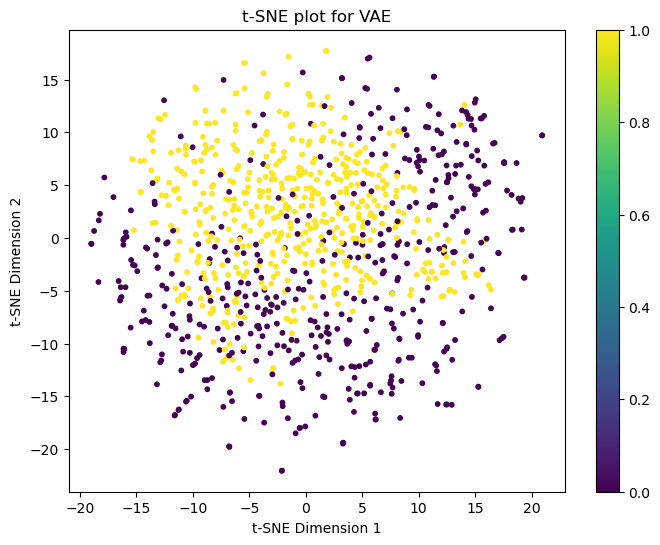

In [92]:
from sklearn.manifold import TSNE

vae.eval()
latent_space = []
labels = []
with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        x, y = data[0], data[1]
        labels.extend(list(y.cpu().numpy()))
        x = x.to(device)
        _, mean, _ = vae(x)
        latent_space.append(mean.cpu().numpy())

latent_space = np.concatenate(latent_space)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_space)

# Plot the t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar()
plt.title('t-SNE plot for VAE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


## Normal Autoencoder

In [55]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [56]:
normal_autoencoder = Autoencoder().to(device)
criterion_autoencoder = nn.MSELoss()
optimizer_autoencoder = torch.optim.Adam(normal_autoencoder.parameters(), lr=0.002)

#### Training

Epoch [1/20], Loss: 0.0222
Epoch [2/20], Loss: 0.0038
Epoch [3/20], Loss: 0.0027
Epoch [4/20], Loss: 0.0023
Epoch [5/20], Loss: 0.0021
Epoch [6/20], Loss: 0.0021
Epoch [7/20], Loss: 0.0020
Epoch [8/20], Loss: 0.0019
Epoch [9/20], Loss: 0.0015
Epoch [10/20], Loss: 0.0014
Epoch [11/20], Loss: 0.0012
Epoch [12/20], Loss: 0.0011
Epoch [13/20], Loss: 0.0011
Epoch [14/20], Loss: 0.0011
Epoch [15/20], Loss: 0.0010
Epoch [16/20], Loss: 0.0011
Epoch [17/20], Loss: 0.0010
Epoch [18/20], Loss: 0.0010
Epoch [19/20], Loss: 0.0010
Epoch [20/20], Loss: 0.0009


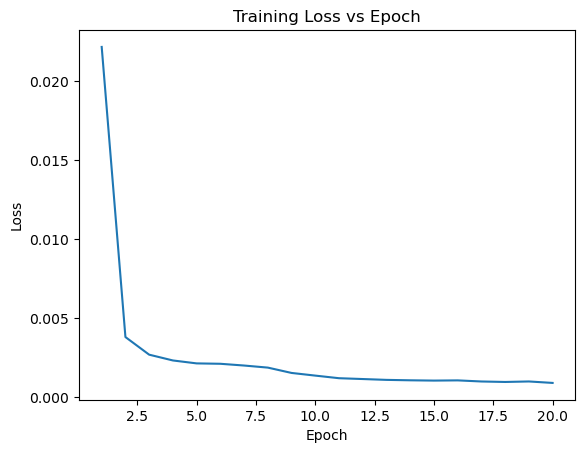

In [75]:
import matplotlib.pyplot as plt

def train_autoencoder(model, criterion, optimizer, dataloader, num_epochs):
    train_losses = []
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, data in enumerate(dataloader):
            
            x, y = data[0], data[1]
            data = x.to(device)
            optimizer.zero_grad()
            recon_batch = model(data)
            loss = criterion(recon_batch, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        
        # Print epoch statistics
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, avg_loss))

    # Plot training loss curve
    plt.plot(range(1, num_epochs+1), train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epoch')
    plt.show()


train_autoencoder(normal_autoencoder, criterion_autoencoder, optimizer_autoencoder, train_loader, 20)


#### Testing

In [94]:
normal_autoencoder.eval()  
test_loss = 0
test_reconstructions = []
test_originals = []
loss = nn.MSELoss()

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        x, y = data[0], data[1]
        x = x.to(device)
        recon_batch = normal_autoencoder(x)
        test_loss += loss(recon_batch, x).item()
    
        test_reconstructions.append(recon_batch)
        test_originals.append(x)
        
test_loss /= len(test_loader.dataset)

print('Test Loss: {:.4f}'.format(test_loss))

Test Loss: 0.0000


## Taking latent representation of VAE for classification task

In [ ]:
vae.eval()
latent_train = []
labels_train = []

with torch.no_grad():
    for batch_idx, data in enumerate(train_loader):
        x, y = data[0], data[1]
        labels_train.extend(list(y.cpu().numpy()))
        x = x.to(device)
        latent, _, _ = vae.encode(x)
        latent_train.append(latent.cpu().numpy())

latent_train = np.concatenate(latent_train)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

classifier = LogisticRegression()
classifier.fit(latent_train, labels_train)

latent_test = []
labels_test = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        x, y = data[0], data[1]
        labels_test.extend(list(y.cpu().numpy()))
        x = x.to(device)
        mean, log_variance = vae.encode(x)
        latent_test.append(latent.cpu().numpy())

latent_test = np.concatenate(latent_test)

predictions = classifier.predict(latent_test)
accuracy = accuracy_score(labels_test, predictions)

print("Accuracy of the classifier using VAE latent representation:", accuracy)

### Improving the VAE's ability to generate high fidelity and diverse samples.

In [1]:
'''We can improve the ability of VAE to generate high fidelity and diverse images by 3 main methods -

1) Model complexity
Deeper architectures can be used for the encoder and decoder to capture more complex features and generate more diverse images. A more complex latent 
space allows the model to capture finer details and more intricate features of the data distribution, which can be replicated in the reconstructions
and generated images.

2) Residual connections
Using skip connections between the encoder and decoder can help the model to learn more complex features and generate more diverse images. It will reduce
the vanishing gradient problem, allowing the model to more effectively learn complex mappings between the input and output spaces.

3) Vector quantization
Instead of using a continuous latent space, we can use a discrete latent space to generate more diverse images. A discrete representation can 
capture more meaningful and interpretable features of the data distribution compared to continuous latent spaces. The model can focus on capturing 
the most salient aspects of the data distribution, leading to higher fidelity reconstructions.'''

'We can improve the ability of VAE to generate high fidelity and diverse images by 3 main methods -\n\n1) Model complexity\nDeeper architectures can be used for the encoder and decoder to capture more complex features and generate more diverse images. A more complex latent \nspace allows the model to capture finer details and more intricate features of the data distribution, which can be replicated in the reconstructions\nand generated images.\n\n2) Residual connections\nUsing skip connections between the encoder and decoder can help the model to learn more complex features and generate more diverse images. It will reduce\nthe vanishing gradient problem, allowing the model to more effectively learn complex mappings between the input and output spaces.\n\n3) Vector quantization\nInstead of using a continuous latent space, we can use a discrete latent space to generate more diverse images. A discrete representation can \ncapture more meaningful and interpretable features of the data dist